# Change points detection algorithm
- From MoSeq
- Basseville, M., and Nikiforov, I.V. (1993). Detection of abrupt changes (Prentice-Hall Publishing).

In [1]:
""" 
IMPORTS
"""
import os
import autograd.numpy as np
import pickle
import seaborn as sns
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt

# --Machine learning and statistics
from sklearn.preprocessing import StandardScaler, Normalizer
from scipy.ndimage import gaussian_filter1d
from scipy.signal import argrelextrema

from one.api import ONE
one = ONE()


Downloading: /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/tmp_lwsl0w1/cache.zip Bytes: 114186871


100%|██████████| 108.89708614349365/108.89708614349365 [00:30<00:00,  3.57it/s]


## Parameters

In [2]:
bin_size = 0.1

data_path_v1 =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/' + 'v1/' + str(bin_size) + '/'
data_path_v2 =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/' + 'v2_3Nov2023/' + str(bin_size) + '/'
#data_path_v2 =  '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/' + 'v2_3Nov2023/' + str(bin_size) + '/'

data_path = data_path_v2

os.chdir(data_path)
design_matrices = os.listdir(data_path)

if data_path == data_path_v1:
       var_names = ['avg_wheel_vel', 'pupil_diameter',
              'whisker_me', 'nose_speed_X', 'nose_speed_Y', 
              'l_paw_speed_X', 'l_paw_speed_Y', 'pupil_speed_X',
              'pupil_speed_Y', 'Gaussian_licks']
elif data_path == data_path_v2:
       var_names = ['avg_wheel_vel', 'pupil_diameter',
              'whisker_me', 'nose_speed', 'l_paw_speed', 'left_X', 'left_Y',
              'pupil_speed', 'pupil_X', 'pupil_Y', 'Lick count']

# Plotting params
multiplier = 1/bin_size

event_type_list = ['goCueTrigger_times']  # , 'feedback_times', 'firstMovement_times'
event_type_name = ['Go cue']  # , 'Feedback time', 'First movement onset'

## Preprocess list of design matrices

In [49]:
# Save data of all sessions for latter
matrix_all = defaultdict(list)
matrix_all_unnorm = defaultdict(list)
session_all = defaultdict(list)

for m, mat in enumerate(design_matrices[0:1]):
    
    # Trials data
    session = design_matrices[m][14:-4]
    
    #session = '2e6e179c-fccc-4e8f-9448-ce5b6858a183'
    #mat = 'design_matrix_2e6e179c-fccc-4e8f-9448-ce5b6858a183_0.1new_version'
    
    session_trials = one.load_object(session, obj='trials', namespace='ibl')
    session_trials = session_trials.to_df()
    session_end = list(session_trials['stimOff_times'][-1:])[0]  # TODO: this might not work if stimOff times are missing
    session_start = list(session_trials['stimOn_times'])[0]
    
    big_design_matrix = pickle.load(open(mat, "rb"))
    
    design_matrix = big_design_matrix.groupby('Bin')[var_names].mean()  # 
    design_matrix = design_matrix.reset_index(level = [0])  # , 'Onset times'
    design_matrix = design_matrix.dropna()
    
    # Trim design matrix to be as long as the session (otherwise it will include task-unrelated behavior)
    design_matrix = design_matrix.loc[(design_matrix['Bin'] < session_end * 10) & (design_matrix['Bin'] > session_start * 10)]
    training_set = np.array(design_matrix[var_names]).copy() 
    
    if len(training_set) > 0:
      # Standardization using StandardScaler
      scaler = StandardScaler()
      standardized = scaler.fit_transform(training_set)
      # # Normalize between 0 and 1
      normalizer = Normalizer()  # norm='max'
      normalized = normalizer.fit_transform(standardized)
      
    # Save results
    matrix_all[mat].append(normalized)
    # matrix_all[mat].append(normalized)
    session_all[mat].append(session_trials)    
    matrix_all_unnorm[mat].append(design_matrix) 

In [50]:
use_data = design_matrix[var_names].copy()  # To keep the column names
use_data[var_names] = matrix_all[mat][0]

use_data['Lick count'] = gaussian_filter1d(use_data['Lick count'], sigma=1)  # TODO: how to decide on sigma here???
#plt.hist(use_data['Lick count'])

### Parameters
Need to do grid-search on this

In [51]:
k = 4  # bin lag for derivative calculation
h = 01.5  # thresold??
sigma = 0.43  # for Gaussian filter

k = 2
h = 0.5
sigma = 0.7

In [84]:
shuffled_data

,avg_wheel_vel,pupil_diameter,whisker_me,nose_speed,l_paw_speed,left_X,left_Y,pupil_speed,pupil_X,pupil_Y,Lick count
0,-0.064306,0.270863,0.489118,-0.258859,-0.156360,-0.313369,-0.564180,-0.409619,-0.019418,0.011795,-0.087269
1,-0.026018,-0.086716,-0.135127,0.199677,-0.117146,0.007912,-0.212040,0.684096,0.626931,-0.104695,-0.061799
2,-0.055926,0.673698,-0.421323,-0.180771,-0.229552,-0.057964,-0.229034,-0.255637,-0.063072,0.381204,-0.099221
3,-0.449681,0.077804,0.378552,-0.049440,0.169221,-0.078617,-0.356452,0.246790,0.188447,0.620504,-0.059152
4,-0.096927,0.176921,0.576871,-0.122365,0.099141,0.088075,-0.507293,0.561983,-0.056471,0.121655,-0.050396
...,...,...,...,...,...,...,...,...,...,...,...
33735,-0.037731,-0.539940,-0.320836,-0.288167,-0.150559,0.246057,-0.521722,-0.388660,-0.029475,0.098175,-0.065211
33736,-0.037168,0.277854,0.301031,-0.068878,-0.125526,-0.369584,0.486753,0.583978,-0.285733,0.102527,0.242368
33737,-0.037428,-0.562279,-0.307464,-0.210293,-0.149243,0.217099,-0.513059,-0.413299,0.017472,0.189388,-0.063633
33738,-0.028682,-0.128715,-0.126123,0.566292,-0.060586,0.426188,0.286797,-0.199466,0.530913,-0.231035,-0.068921


### Derivative

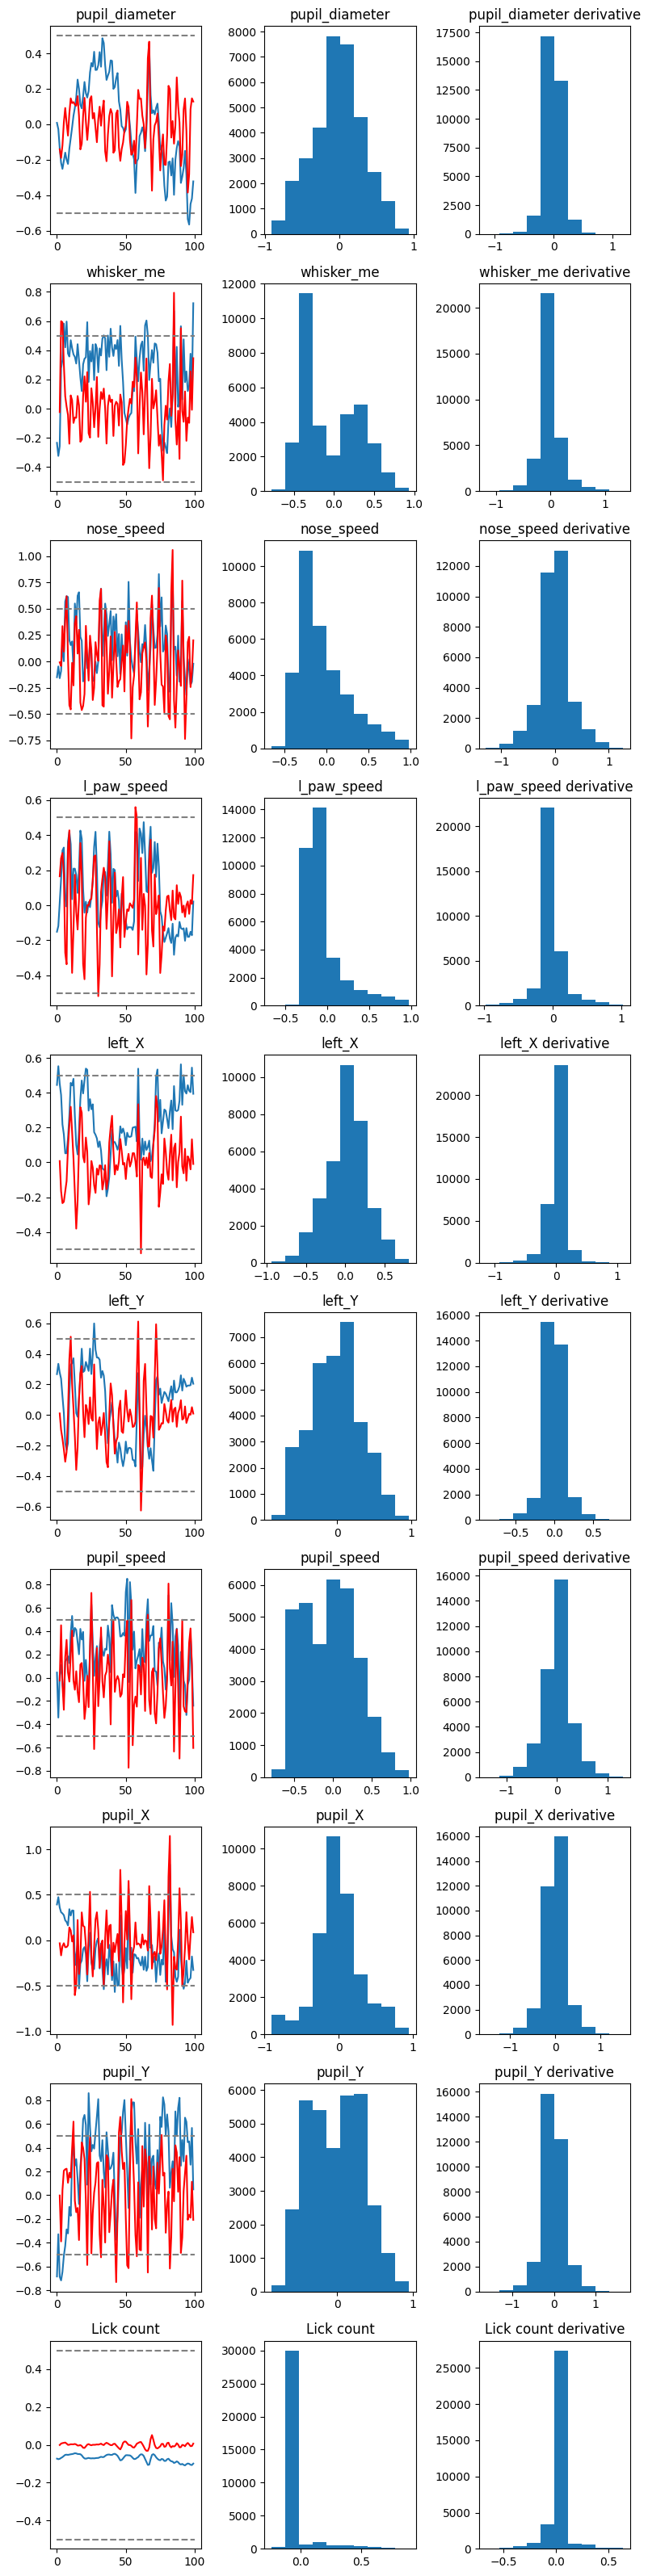

In [87]:
derivative = use_data.copy()
features = use_data.keys()[1:]

min = 0
max = 100

fig, ax = plt.subplots(nrows=len(features) , ncols=3, sharex=False, sharey=False, figsize=[8, 32])

for i, feat in enumerate(features):
    derivative[feat] = derivative[feat] - derivative[feat].shift(k)    
    
    ax[i, 0].plot(use_data[feat][min:max])
    ax[i, 0].plot(derivative[feat][min:max], color='red')
    ax[i, 0].hlines(h, min, max, linestyles='--', color='Gray')
    ax[i, 0].hlines(-h, min, max, linestyles='--', color='Gray')
    ax[i, 2].hist(derivative[feat])
    ax[i, 1].hist(use_data[feat])
    ax[i, 0].set_title(feat)
    ax[i, 2].set_title(str(feat + ' derivative'))
    ax[i, 1].set_title(feat)

plt.tight_layout()


### Thresholding

In [53]:
thresholded = derivative[np.array(features)]

for i, feat in enumerate(features):
    # thresholded[pc] = thresholded[pc] * np.nan
    thresholded.loc[(thresholded[feat] >= -h) & (thresholded[feat] <= h), feat] = 0
    thresholded.loc[thresholded[feat] > h, feat] = 1
    thresholded.loc[thresholded[feat] < -h, feat] = 1

summed_threshold = np.sum(thresholded, axis=1)
# overall_thresold = np.array(summed_threshold)
# overall_thresold[np.where(summed_thresold>=5)] = 1
# overall_thresold[np.where(summed_thresold<5)] = 0

/tmp/ipykernel_10550/1722447556.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thresholded.loc[(thresholded[feat] >= -h) & (thresholded[feat] <= h), feat] = 0
/tmp/ipykernel_10550/1722447556.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thresholded.loc[thresholded[feat] > h, feat] = 1
/tmp/ipykernel_10550/1722447556.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thresholded.loc[thresholded[feat] < -h, feat] = 1


### Gaussian filter

In [54]:
# Apply Gaussian filter
# smoothed_signal = gaussian_filter1d(overall_thresold, sigma=sigma)
smoothed_signal = gaussian_filter1d(summed_threshold, sigma=sigma)

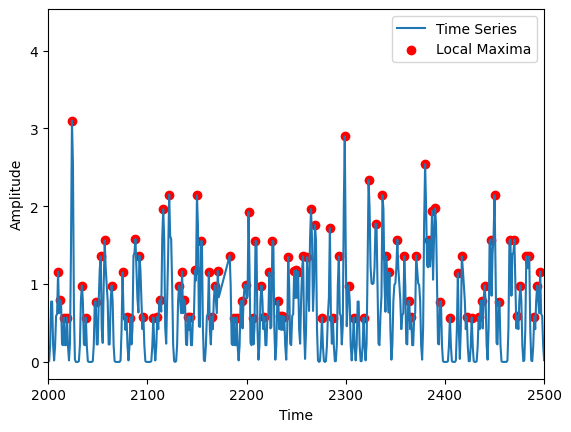

In [55]:
local_maxima = argrelextrema(smoothed_signal, np.greater)

time = design_matrix['Bin']
# Plot the time series and local maxima
plt.plot(time, smoothed_signal, label='Time Series')
plt.scatter(time[local_maxima[0]], smoothed_signal[local_maxima[0]], color='red', label='Local Maxima')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.xlim([2000, 2500])
plt.show()

### Control data

In [10]:
shuffled_data = use_data.copy()
shuffled_data = shuffled_data.sample(frac=1).reset_index(drop=True)

#shuffled_data = shuffled_data.sample(frac=1, axis=0).sample(frac=1, axis=1)

### Grid serach

In [98]:
def changepoint_detection(data, k, h1, h2, sigma):

    # Initialize
    derivative = data.copy()
    
    # Find first derivative and threshold
    #features = data.keys()[1:]
    features = data.keys()
    for i, feat in enumerate(features):
        derivative[feat] = derivative[feat] - derivative[feat].shift(k)    
    
    thresholded = derivative.copy()
    for i, feat in enumerate(features):
        # Thresold derivative
        thresholded.loc[(thresholded[feat] >= -h1) & (thresholded[feat] <= h1), feat] = 0
        thresholded.loc[thresholded[feat] >= h1, feat] = 1
        thresholded.loc[thresholded[feat] <= -h1, feat] = 1
    
    # Sum ove thresholded data
    summed_threshold = np.sum(thresholded, axis=1)
    # Apply Gaussian filter
    smoothed_signal = gaussian_filter1d(summed_threshold, sigma=sigma)
    
    # Detect local maxima
    local_maxima = argrelextrema(smoothed_signal, np.greater)
    
    # Keep local maxima is above a threshold
    crit = smoothed_signal[local_maxima[0]] > h2
    changepoints = local_maxima[0][crit]
    
    return changepoints, smoothed_signal

In [99]:
sigma = 0.8
k = 2
h1 = .5
h2 = 1.9

In [137]:
ks = [2, 3, 4, 5, 6]  # bin lag for derivative calculation
ks = [2, 3, 4]
ks = [2]
hs1 = [0.1, 0.2, 0.3, 0.4, 0.45, 0.5, 0.55, 0.6, 0.7, 1, 1.4, 1.5, 1.6, 1.7, 2, 2.5, 2.9, 3]  # thresold??
hs2 = [0.5, 0.6, 0.7, 1, 1.4, 1.5, 1.6, 1.7, 1.8, 1.85, 1.9, 1.95, 2, 2.5, 3]  # thresold??
sigmas = [0.3, 0.5, 0.6, 0.7, 0.75, 0.8, 0.81, 0.82, 0.83, 0.85, 0.9, 0.95, 1, 2, 3]  # for Gaussian filter

results_data = {}
smoothed_data = {}
results_control ={}
summary_results = {}

features = use_data.keys()   # [1:]

# Shuffle the data
shuffled_data = use_data.copy()
shuffled_data = shuffled_data.sample(frac=1).reset_index(drop=True)  # Shuffle columns as well
#shuffled_data[np.array(features)] = shuffled_data[np.array(features)].sample(frac=1, axis=0).sample(frac=1, axis=1)  # Shuffle both rows and columns

for ik, k in enumerate(ks):
    results_data[k] = {}
    smoothed_data[k] = {}
    results_control[k] = {}
    summary_results[k] = {}
    
    for ih, h1 in enumerate(hs1):
        results_data[k][h1] = {}
        smoothed_data[k][h1] = {}
        results_control[k][h1] = {}
        summary_results[k][h1] = {}

        for ih, h2 in enumerate(hs2):
            results_data[k][h1][h2] = {}
            smoothed_data[k][h1][h2] = {}
            results_control[k][h1][h2] = {}
            summary_results[k][h1][h2] = {}
        
            for isig, sigma in enumerate(sigmas):
            
                """ Data """
                data_changepoints, smoothed_signal = changepoint_detection(use_data, k, h1, h2, sigma)
                
                """ Control """
                shuffled_changepoints, _ = changepoint_detection(shuffled_data, k, h1, h2, sigma)
                
                """ Save results """
                results_data[k][h1][h2][sigma] = data_changepoints 
                smoothed_data[k][h1][h2][sigma] = smoothed_signal
                results_control[k][h1][h2][sigma] = shuffled_changepoints 
                summary_results[k][h1][h2][sigma] = [len(data_changepoints), len(shuffled_changepoints)]


In [147]:
expected_lag = 10
threshold = len(smoothed_signal)/(10*expected_lag)  # Allow for shuffled data to detect changepoints around once every 100 sec

max_changepoints = []
keys = []
for ik, k in enumerate(ks):
    
    for ih2, h1 in enumerate(hs1):
        
        for ih2, h2 in enumerate(hs2):
    
            for isig, sigma in enumerate(sigmas):
                #if summary_results[k][h1][h2][sigma][1] == 0:
                if summary_results[k][h1][h2][sigma][1] <= threshold:

                    if len(max_changepoints) == 0:
                        max_changepoints = [summary_results[k][h1][h2][sigma][0]]
                        keys = [k, h1, h2, sigma]
                    else:
                        max_changepoints = np.vstack((max_changepoints, summary_results[k][h1][h2][sigma][0]))
                        keys = np.vstack((keys, [k, h1, h2, sigma]))


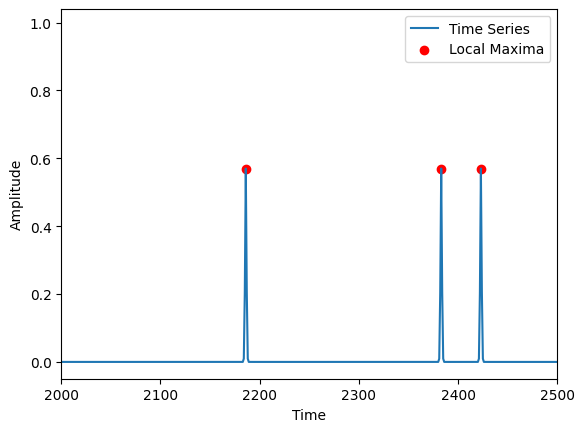

In [148]:
local_maxima = argrelextrema(smoothed_signal, np.greater)

time = design_matrix['Bin']
# Plot the time series and local maxima
plt.plot(time, smoothed_signal, label='Time Series')
plt.scatter(time[local_maxima[0]], smoothed_signal[local_maxima[0]], color='red', label='Local Maxima')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.xlim([2000, 2500])
plt.show()

In [149]:
flat_changepoints = max_changepoints.ravel()
use_keys = keys[flat_changepoints==np.max(flat_changepoints)]
use_keys

array([[2.  , 1.5 , 0.5 , 0.85],
       [2.  , 1.5 , 0.5 , 0.9 ],
       [2.  , 1.5 , 0.5 , 0.95],
       [2.  , 1.5 , 0.5 , 1.  ]])

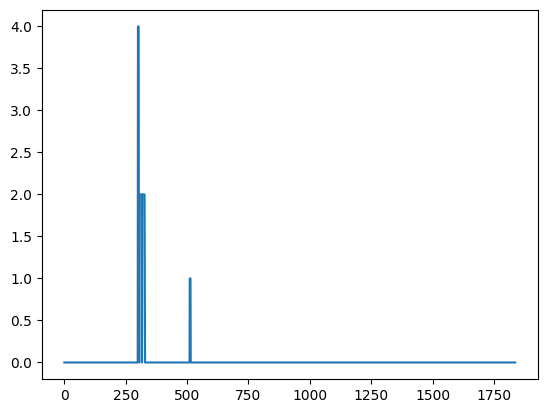

In [150]:
plt.plot(max_changepoints)

### Optimal changepoints

In [142]:
sigma = 0.8
k = 2
h1 = 0.5
h2 = 1

k = int(use_keys[0][0])
h1 = float(use_keys[0][1])
h2 = float(use_keys[0][2])
sigma = float(use_keys[0][3])

data_changepoints, smoothed_signal = changepoint_detection(use_data, k, h1, h2, sigma)
shuffled_changepoints, smoothed_shuff = changepoint_detection(shuffled_data, k, h1, h2, sigma)

In [143]:
use_data

,avg_wheel_vel,pupil_diameter,whisker_me,nose_speed,l_paw_speed,left_X,left_Y,pupil_speed,pupil_X,pupil_Y,Lick count
0,-0.040864,0.008135,-0.233432,-0.150326,-0.150832,0.445143,0.267789,0.044518,0.393392,-0.683561,-0.073089
1,-0.060396,-0.027710,-0.323080,-0.047746,-0.118164,0.553001,0.335435,-0.342506,0.473742,-0.328128,-0.076045
2,-0.051345,-0.132856,-0.256422,-0.159178,0.014572,0.452773,0.278356,0.020299,0.360299,-0.685770,-0.074080
3,-0.118243,-0.217515,0.276170,-0.091319,0.150669,0.387632,0.237923,0.108488,0.308001,-0.716502,-0.069378
4,-0.353650,-0.251437,0.335073,0.175852,0.312642,0.218313,0.122358,-0.039340,0.295119,-0.644155,-0.065084
...,...,...,...,...,...,...,...,...,...,...,...
33735,-0.057510,-0.087648,-0.472501,-0.381054,-0.224580,-0.052357,-0.219147,-0.581375,-0.335891,0.243304,-0.097070
33736,-0.058573,-0.076131,-0.460000,-0.451729,-0.231396,-0.051966,-0.223216,-0.539091,-0.364137,0.190127,-0.097080
33737,-0.057048,-0.072002,-0.463179,-0.410579,-0.225592,-0.050409,-0.217426,-0.580009,-0.374618,0.147688,-0.096768
33738,-0.057497,-0.072424,-0.453680,-0.404082,-0.227286,-0.051385,-0.219165,-0.559096,-0.398946,0.197318,-0.096770


In [144]:
shuffled_data

,avg_wheel_vel,pupil_diameter,whisker_me,nose_speed,l_paw_speed,left_X,left_Y,pupil_speed,pupil_X,pupil_Y,Lick count
0,-0.032104,0.137438,-0.249021,-0.258476,-0.126474,0.147744,0.063201,-0.001837,-0.829134,-0.345006,-0.055132
1,-0.047088,-0.385105,-0.323461,-0.289106,-0.166012,0.526884,0.329813,-0.415235,-0.107084,0.241775,-0.071000
2,-0.029085,-0.171189,-0.235319,-0.207832,-0.106953,0.348459,0.243903,-0.169089,-0.744413,-0.306061,-0.051426
3,-0.014289,0.007264,-0.096031,0.302823,-0.137841,0.142620,-0.302763,0.821374,0.089718,0.284896,-0.074079
4,-0.063853,-0.342139,-0.356195,-0.378565,-0.233223,0.188553,-0.226250,-0.609339,-0.060684,0.287282,-0.099540
...,...,...,...,...,...,...,...,...,...,...,...
33735,-0.046433,-0.068217,-0.425278,-0.243373,-0.191986,0.251956,-0.376415,-0.356156,0.076021,-0.609169,-0.086324
33736,-0.042806,-0.263419,-0.329724,-0.231130,-0.176943,0.557275,0.350429,-0.482730,-0.059962,0.244326,-0.074271
33737,-0.030120,0.143587,-0.246321,-0.109340,-0.127683,0.259455,0.070506,0.151338,-0.835908,-0.304308,-0.060130
33738,-0.047361,-0.147786,-0.087314,0.606010,0.521872,-0.055172,0.018091,-0.446599,-0.285964,0.191466,-0.087224


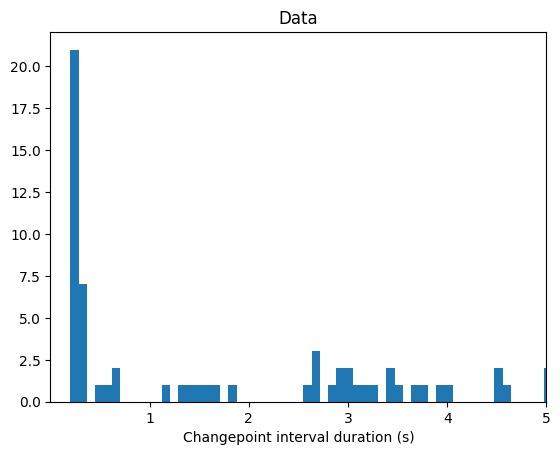

62.0
74.5


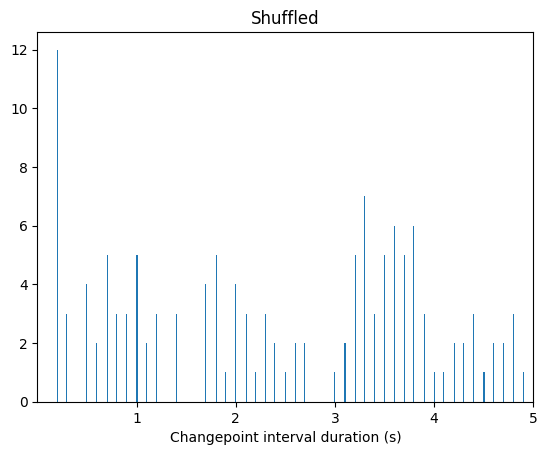

In [145]:
plt.hist(np.diff(data_changepoints), bins=5000)
plt.xlim([0, 50])
plt.xlabel('Changepoint interval duration (s)')
plt.xticks([10, 20, 30, 40, 50], [1, 2, 3, 4, 5])
plt.title('Data')
plt.show()

plt.hist(np.diff(shuffled_changepoints), bins=5000)
plt.xlim([0, 50])
plt.xlabel('Changepoint interval duration (s)')
plt.xticks([10, 20, 30, 40, 50], [1, 2, 3, 4, 5])
plt.title('Shuffled')

print(np.median(np.diff(data_changepoints)))
print(np.median(np.diff(shuffled_changepoints)))


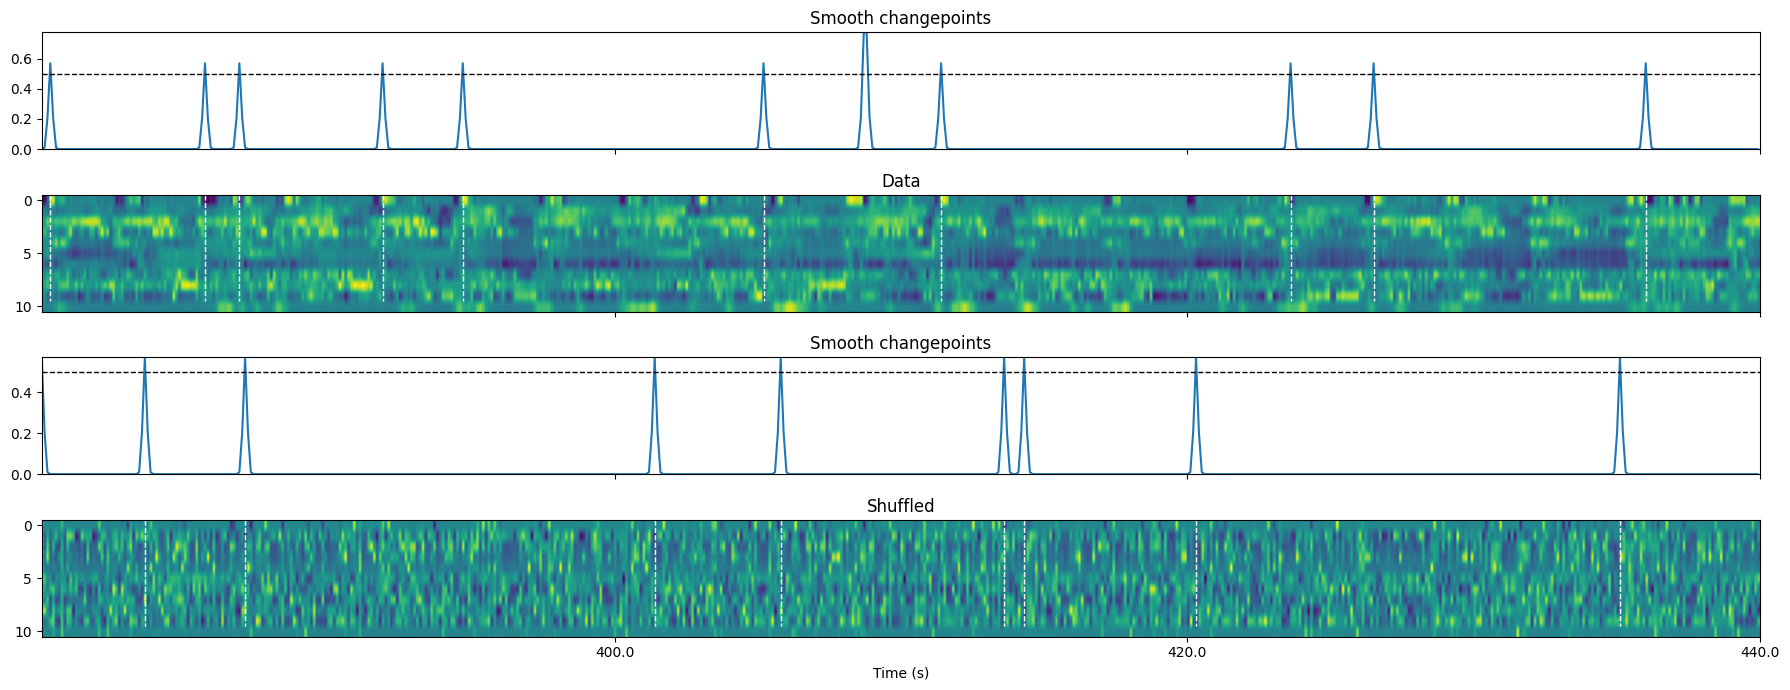

In [146]:
fig, ax = plt.subplots(nrows=4 , ncols=1, sharex=True, sharey=False, figsize=[18, 7])

interval = 600
init = 4000
end = init + interval

matrix = np.array(use_data[np.array(features)]).transpose()
shuf_matrix = np.array(shuffled_data[np.array(features)]).transpose()
vlines_data = data_changepoints - init
vlines_shuf = shuffled_changepoints - init

# Plot the data matrix
ax[0].plot(smoothed_signal[init:end])
ax[0].hlines([h2], 0, interval, color='black', linewidth=1, linestyles='--')
ax[0].set_title('Smooth changepoints')
ax[0].set_ylim([np.min(smoothed_signal[init:end]), np.max(smoothed_signal[init:end])])

# Plot the data matrix
im1 = ax[1].imshow(matrix[:, init:end], aspect='auto')
ax[1].vlines(vlines_data, -0.5, 9.5, color='white', linewidth=1, linestyles='--')
ax[1].set_title('Data')

# Plot the data matrix
ax[2].plot(smoothed_shuff[init:end])
ax[2].hlines([h2], 0, interval, color='black', linewidth=1, linestyles='--')
ax[2].set_title('Smooth changepoints')
ax[2].set_ylim([np.min(smoothed_shuff[init:end]), np.max(smoothed_shuff[init:end])])


# Plot the control matrix
im2 = ax[3].imshow(shuf_matrix[:, init:end], aspect='auto')
ax[3].vlines(vlines_shuf, -0.5, 9.5, color='white', linewidth=1, linestyles='--')
ax[3].set_xlabel('Time (s)')
ax[3].set_xlim([0, interval])
ax[3].set_title('Shuffled')
# labels = [init/10 , init/10+20, init/10+40, init/10+60, init/10+80]
# ax[2].set_xticks([200, 400, 600, 800, 1000], labels)
labels = [init/10 , init/10+20, init/10+40]
ax[3].set_xticks([200, 400, 600], labels)
#ax[2].set_xticks([100, 200, 300], labels)

plt.tight_layout()

## Add colorbar
#cbar1 = fig.colorbar(im1, ax=ax[1])
#cbar2 = fig.colorbar(im2, ax=ax[2])


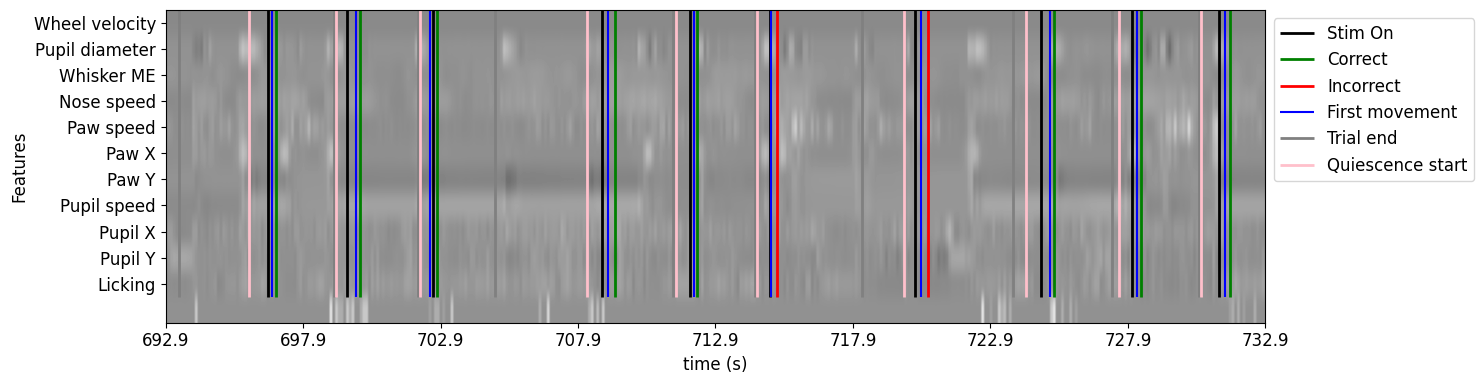

In [31]:
init = 6000
end = init + 400
plt.rc('font', size=12)

fig, axs = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(15, 4))

cmap = plt.cm.gray
use_data = scaler.fit_transform(X)
im1 = axs.imshow(use_data.transpose(), aspect='auto', cmap=cmap)  # [:, init:end]
bin_init = design_matrix['Bin'][0]


axs.vlines(np.array(session_trials['goCueTrigger_times'] * 10 - bin_init),-0.5, 10.5, label='Stim On', color='Black', linewidth=2)
axs.vlines(np.array(session_trials.loc[session_trials['feedbackType']==1, 'feedback_times'] * 10 - bin_init), -0.5, 10.5, label='Correct', color='Green', linewidth=2)
axs.vlines(np.array(session_trials.loc[session_trials['feedbackType']==-1, 'feedback_times'] * 10 - bin_init), -0.5, 10.5, label='Incorrect', color='Red', linewidth=2)
axs.vlines(np.array(session_trials['firstMovement_times'] * 10 - bin_init), -0.5, 10.5, label='First movement', color='Blue')
axs.vlines(np.array(session_trials['intervals_0'] * 10 - bin_init), -0.5, 10.5, label='Trial end', color='Grey', linewidth=2)
axs.vlines(np.array((session_trials['goCueTrigger_times'] - session_trials['quiescencePeriod']) * 10 - bin_init), -0.5, 10.5, label='Quiescence start', color='Pink', linewidth=2)
#axs.set_ylim(0, 1)

axs.set_ylabel("Features")
axs.set_xlabel("time (s)")
axs.set_xlim(init, end)
axs.set_xticks(np.arange(init, end+50, 50),np.arange((init+bin_init)/10, (end+bin_init)/10+5, 5))
feature_names = ['Wheel velocity', 'Pupil diameter', 'Whisker ME', 'Nose speed', 'Paw speed', 'Paw X', 'Paw Y', 'Pupil speed', 'Pupil X', 'Pupil Y', 'Licking']
axs.set_yticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], feature_names)
axs.legend(loc='upper left', bbox_to_anchor=(1, 1))
cbar1 = fig.colorbar(im1, ax=ax)

plt.tight_layout()
plt.show()

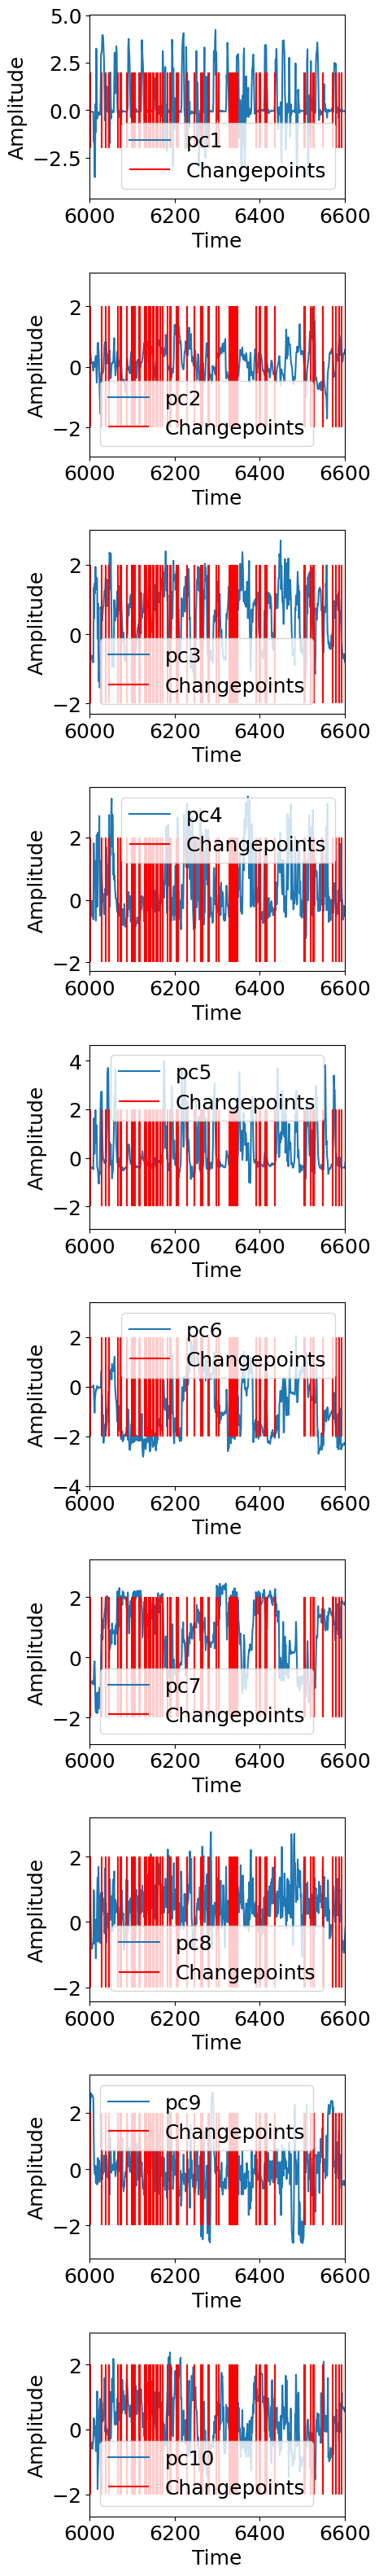

In [296]:
derivative = augmented_data.copy()
pcs = augmented_data.keys()[1:]

min = 6000
max = min + 600

fig, ax = plt.subplots(nrows=len(pcs) , ncols=1, sharex=False, sharey=False, figsize=[5, 32])

for i, pc in enumerate(pcs):
    
    #time = augmented_data['Bin']
    time = np.arange(0, len(augmented_data['Bin']), 1)
    # Plot the time series and local maxima
    ax[i].plot(time, augmented_data[pc], label=pc)
    ax[i].vlines(data_changepoints, -2, 2, color='red', label='Changepoints')
    ax[i].legend()
    ax[i].set_xlabel('Time')
    ax[i].set_ylabel('Amplitude')
    ax[i].set_xlim([min, max])
    
plt.tight_layout()
